# 젠더 법안 K-means

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
from gensim import models
import fasttext.util
from sklearn.cluster import AgglomerativeClustering
from konlpy.tag import Okt
import logging
%matplotlib inline

In [3]:
bill_df = pd.read_csv('./2021-bill-preprocessed.csv', 
                      index_col=0, parse_dates=['제안일자','의결일자','의결처리기간'] )
bill_df.drop('Unnamed: 13',1, inplace=True)
print(bill_df.shape)
bill_df.columns

(26140, 38)


Index(['의안번호', '의안명', '제안자구분', '제안일자', '의결일자', '의결결과', '제안회기', '제안이유', '소관위원회',
       '제안정당', '법률반영여부', '법률안', '개혁보수신당', '국민의당', '기본소득당', '대안신당', '대한애국당',
       '더불어민주당', '더불어시민당', '무소속', '미래를향한전진4.0', '미래통합당', '미래한국당', '민생당',
       '민주평화당', '민중당', '바른미래당', '바른정당', '새누리당', '새로운보수당', '새민중정당', '시대전환',
       '열린민주당', '우리공화당', '자유한국당', '정의당', '의결처리기간', '법률공포여부'],
      dtype='object')

In [30]:
# 의안번호 2014046 2018년 먼저 다크웹 규제 강화 법안 발의 but 임기만료폐기 
keyword = r'.*(N번방|n번방|불법촬영|스토킹|데이트폭력|데이트 폭력|디지털성범죄|사이버범죄|포르노|\
                카르텔|과다노출|사이버 범죄|몰래카메라|몰카|불법 촬영|몸캠|성폭력|성착취|성매매|성범죄|\
                버닝썬|성희롱|딥페이크|복제물|음란|성범죄|n번방|웹하드|촬영물|클럽|성접대|미투|그루밍|성희롱).*'
gender = bill_df[bill_df['의안명'].str.match(keyword) |
           bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
gender = gender.reset_index()
gender = gender.drop('index',1)
gender.shape

(1016, 38)

In [31]:
gender = gender[['의안번호','의안명','의결결과','제안이유']]
gender.head()

,의안번호,의안명,의결결과,제안이유
0,2024979,아동·청소년의 성보호에 관한 법률 일부개정법률안,원안가결,2 대안의 아동？청소년 음란물 범죄의 규모와 형태가 갈수록 교묘해지고 있지만 우...
1,2024963,정보통신망 이용촉진 및 정보보호 등에 관한 법률 일부개정법률안,원안가결,대안의 가 현행법상 금지되는 정보통신망 침해행위에 최근 정보통신망의 정상적인 보호...
2,2024959,전기통신사업법 일부개정법률안,원안가결,2 대안의 일부 기간통신사업자의 서비스별 요금 등에 관한 이용약관에 대하여 인가제...
3,2024926,아동·청소년의 성보호에 관한 법률 일부개정법률안,임기만료폐기,최근 N번방 사건으로 불리는 텔레그램을 통한 아동 청소년 성착취 사건으로 인해 사회...
4,2024925,특정강력범죄의 처벌에 관한 특례법 일부개정법률안,임기만료폐기,최근 N번방 사건으로 불리는 텔레그램을 통한 아동？청소년 성착취 사건으로 사회적 공...


In [75]:
keyword = r'.*(금고이상의).*'
hahaha = bill_df[bill_df['의안명'].str.match(keyword) |
           bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
hahaha = hahaha.reset_index()
hahaha = hahaha.drop('index',1)
hahaha.shape

(6, 38)

In [76]:
hahaha['제안이유'][0]

'「국민체육진흥법」 및 같은 법 시행령에서는 선수 및 지도자의 보호 육성을 위해 장려금을 지급하도록 규정하고 있으며  장려금의 지급대상자 선정 및 지급기준 방법 등에 관하여 필요한 사항은 문화체육관광부장관이 정하도록 하고 있음에 따라 문화체육관광부장관은 「체육인복지사업운영규정」을 두어 선수 및 지도자에게 장려금을 지급하고 있음 다만  「국민체육진흥법」상에 장려금의 지급은 규정되어 있으나 수령자격의 상실 등에 대해서는 문화체육관광부장관 훈령에 규정하여 운영하고  장려금의 환수에 대한 별도의 규정 또한 마련해두고 있지 않아 금고이상의 형이 확정된 수령자의 자격박탈을 위한 범죄경력자료 확인과 그 지급액의 환수에 어려움을 겪고 있음 이에 현행 「체육인복지사업운영규정」에 기반하여 운영되고 있는 장려금 수령자격의 상실 및 환수 기준을 「국민체육진흥법」에 규정하고  「국민체육진흥법」에 규정되어 있는 전산망 등에 의해 조회할 수 있는 자료 등에 범죄경력자료를 포함하여 합리적 국가예산 집행을 도모하려는 것임(안 제14조제5항  제22조의2제1항) '

In [32]:
gender['제안이유'][0]

'2  대안의 아동？청소년 음란물 범죄의 규모와 형태가 갈수록 교묘해지고 있지만  우리나라의 아동 대상 성범죄에 대한 처벌이 지나치게 관대해 실효성이 떨어진다는 비판이 커지고 있는 바  이에 아동？청소년 대상 성범죄의 경우 형의 하한을 설정하고  예비 음모 및 구입 시청 광고 소개하는 경우에도 처벌받도록 하여 경각심을 제고할 필요가 있음 또한  아동 청소년을 대상으로 하는 음란물은 그 자체로 아동 청소년에 대한 성착취 및 학대를 의미하는 것임에도 불구하고  막연히 아동 청소년을 ‘이용’하는 음란물의 의미로 가볍게 해석되는 경향이 있어 온 바  이에 “아동 청소년이용음란물”을 “아동 청소년성착취물”이라는 용어로 변경해 아동청소년이용음란물이 ‘성착취 성학대’ 임을 명확하게 할 필요가 있음 그 밖에 아동 청소년성착취물의 배포 제공 광고 소개 및 구입 소지 시청 등의 죄에 대한 벌금형을 삭제함에 따라 이를 조정하고  아동 청소년이용음란물 범죄를 수사기관에 신고한 자에 대해 신고포상금을 지급할 수 있도록 하여 아동 청소년의 성보호를 강화할 필요가 있음 3  대안의 주요내용가  ‘아동 청소년이용음란물’을 ‘아동 청소년성착취물’로 그 용어를 변경함(안 제2조제5호  안 제12조  안 제17조)나  아동ㆍ청소년에 대한 강간ㆍ강제추행 등의 죄를 범할 목적으로 예비 또는 음모한 경우 처벌하도록 함(안 제7조의2 신설) 다  아동 청소년성착취물의 제작 배포 등에 관한 죄의 형량을 강화함(안 제11조) 라  아동 청소년성착취물의 배포 제공 광고 소개 및 구입 소지 시청 등의 죄에 대한 벌금형이 삭제됨에 따라 이를 조정함(안 제56조제1항) 마  아동 청소년성착취물의 제작 배포 등에 관한 죄를 신고한 사람에게 포상금을 지급할 수 있도록 함(안 제59조제1항) '

In [33]:
gender['제안이유'] = gender['제안이유'].apply(lambda x: str(x).lower().strip())

In [34]:
gender_text = gender['제안이유'].to_list()

In [35]:
from krwordrank.hangle import normalize

gender_text = [normalize(text, english=True, number=True) for text in gender_text]

In [36]:
gender_text[0]

'2 대안의 아동 청소년 음란물 범죄의 규모와 형태가 갈수록 교묘해지고 있지만 우리나라의 아동 대상 성범죄에 대한 처벌이 지나치게 관대해 실효성이 떨어진다는 비판이 커지고 있는 바 이에 아동 청소년 대상 성범죄의 경우 형의 하한을 설정하고 예비 음모 및 구입 시청 광고 소개하는 경우에도 처벌받도록 하여 경각심을 제고할 필요가 있음 또한 아동 청소년을 대상으로 하는 음란물은 그 자체로 아동 청소년에 대한 성착취 및 학대를 의미하는 것임에도 불구하고 막연히 아동 청소년을 이용 하는 음란물의 의미로 가볍게 해석되는 경향이 있어 온 바 이에 아동 청소년이용음란물 을 아동 청소년성착취물 이라는 용어로 변경해 아동청소년이용음란물이 성착취 성학대 임을 명확하게 할 필요가 있음 그 밖에 아동 청소년성착취물의 배포 제공 광고 소개 및 구입 소지 시청 등의 죄에 대한 벌금형을 삭제함에 따라 이를 조정하고 아동 청소년이용음란물 범죄를 수사기관에 신고한 자에 대해 신고포상금을 지급할 수 있도록 하여 아동 청소년의 성보호를 강화할 필요가 있음 3 대안의 주요내용가 아동 청소년이용음란물 을 아동 청소년성착취물 로 그 용어를 변경함 안 제2조제5호 안 제12조 안 제17조 나 아동 청소년에 대한 강간 강제추행 등의 죄를 범할 목적으로 예비 또는 음모한 경우 처벌하도록 함 안 제7조의2 신설 다 아동 청소년성착취물의 제작 배포 등에 관한 죄의 형량을 강화함 안 제11조 라 아동 청소년성착취물의 배포 제공 광고 소개 및 구입 소지 시청 등의 죄에 대한 벌금형이 삭제됨에 따라 이를 조정함 안 제56조제1항 마 아동 청소년성착취물의 제작 배포 등에 관한 죄를 신고한 사람에게 포상금을 지급할 수 있도록 함 안 제59조제1항'

In [38]:
for word, r in sorted(keywords.items(), key=lambda x:x[1], reverse=True)[:30]:
    print('%8s:\t%.4f' % (word, r))

      대한:	62.3382
      신설:	51.3066
      또는:	51.0959
      있음:	47.0143
      경우:	46.6906
      이에:	41.6540
      아동:	35.8291
      피해:	34.0511
     성폭력:	33.3207
      있는:	31.2659
      것임:	25.6936
      하고:	24.2480
      관한:	24.2233
      등을:	21.8113
     위하여:	19.9280
     성범죄:	19.8297
      하는:	19.7012
     성희롱:	19.6288
      등에:	19.5808
      현행:	19.1915
      처벌:	19.0562
      등의:	18.8179
      최근:	18.7384
      보호:	17.8072
      따른:	17.7786
     청소년:	16.4167
      범죄:	16.3101
      제1:	16.1638
      해당:	16.0889
      따라:	15.4335


In [37]:
from krwordrank.word import KRWordRank 

wordrank_extractor = KRWordRank( 
                                min_count=5,
                                max_length = 10, 
                                verbose = True)
beta = 0.85 
max_iter = 10 

keywords, rank, graph = wordrank_extractor.extract(gender_text, beta, max_iter)

scan vocabs ... 
num vocabs = 15573
done = 10 Early stopped.


In [47]:
from wordcloud import WordCloud 

text4wc = ' '.join(gender_text)
wordcloud = WordCloud()
wordcloud = wordcloud.generate_from_text(text4wc)
# wordcloud = wordcloud.generate_from_frequencies(keywords)

In [89]:
# 단순 빈도수 
from wordcloud import WordCloud 
from wordcloud import STOPWORDS

stopwords = {'사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정','대한',\
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',\
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지','또는','있음','경우','이에','있는',\
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어','것임','하고','관한','등을','위하여',\
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해','하는','등에','등의','최근','따른',\
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이','제1','해당','따라','하지만',\
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서','함으로써','한편',\
             '경우에는','법률','그러나','대하여','규정하고','그런데','이를','주요내용가','이유로','있는데','통하여','제12조','있으나','하며',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',\
             '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등','안','바','이','것','부터','수','시','자'}

wordcloud = WordCloud(stopwords=stopwords)
wordcloud = wordcloud.generate_from_text(text4wc)

In [90]:
from wordcloud import WordCloud 

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
wordcloud = WordCloud(font_path = font_path, 
                      stopwords=stopwords, 
                      width = 800, 
                       height = 800)

wordcloud = wordcloud.generate_from_text(text4wc)
# wordcloud = wordcloud.generate_from_frequencies(keywords)

In [91]:
def __array__(self):
    """Convert to numpy array.
    Returns
    -------
    image : nd-array size (width, height, 3)
        Word cloud image as numpy matrix.
    """
    return self.to_array()

def to_array(self):
    """Convert to numpy array.
    Returns
    -------
    image : nd-array size (width, height, 3)
        Word cloud image as numpy matrix.
    """
    return np.array(self.to_image())

array = wordcloud.to_array()
print(type(array))
print(array.shape)

<class 'numpy.ndarray'>
(800, 800, 3)


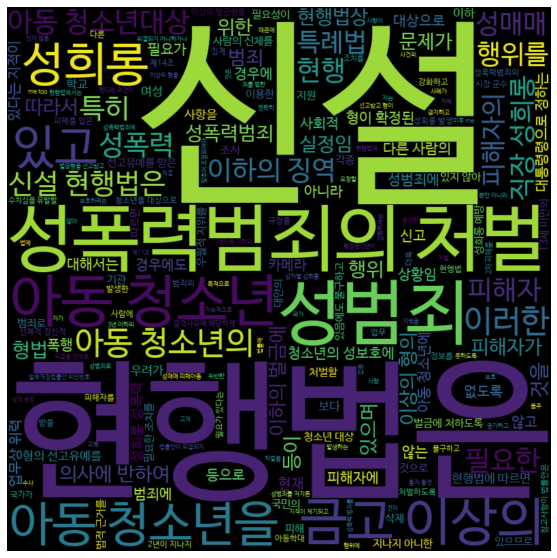

In [92]:
# grouped_color_func = GroupedColorFunc(color_to_words, default_color)
# wordcloud.recolor(color_func=grouped_color_func)
fig = plt.figure(figsize=(10, 10))
plt.imshow(array, interpolation='bilinear')
plt.axis("off")
plt.show()    